# TESS TCE Finder

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install astroquery

In [2]:
from functools import lru_cache
import re
import warnings

import numpy as np

from astropy.table import Table

from astroquery.exceptions import NoResultsWarning
from astroquery.mast import Observations

from ipywidgets import interact, interactive
import ipywidgets as widgets
from IPython.core.display import display, HTML

In [3]:
def parse_dvs_filename(filename):
    # e.g.: tess2020267090513-s0030-s0030-0000000142087638-01-00394_dvs.pdf
    match = re.match(r"^tess\d+-(s\d+-s\d+)-(\d+)-(\d+)-.+_dvs[.]pdf", filename)
    if not match:
        return {}
    sector_range, tic_id_padded, tce_num_padded = (
        match.group(1),
        match.group(2),
        match.group(3),
    )
    tic_id = re.sub(r"^0+", "", tic_id_padded)
    tce_num = re.sub(r"^0+", "", tce_num_padded)
    # sufficient to identify one for a given TIC, less visually busy
    tce_id_short = f"{sector_range}:TCE{tce_num}"

    # tce_id is the format used on ExoMAT, e.g,  TIC142087638S0030S0030TCE1
    tce_id = f"""TIC{tic_id}{re.sub("-", "", sector_range.upper())}TCE{tce_num}"""

    return dict(
        tce_id=tce_id,
        tce_id_short=tce_id_short,
        sector_range=sector_range,
        tic_id=tic_id,
        tce_num=tce_num,
    )


def parse_dvr_filename(filename):
    match = re.match(r"^tess\d+-(s\d+-s\d+)-(\d+)-.+_dvr[.](pdf|xml)", filename)
    if not match:
        return {}
    sector_range, tic_id_padded, file_type = (
        match.group(1),
        match.group(2),
        match.group(3),
    )
    tic_id = re.sub(r"^0+", "", tic_id_padded)

    return dict(sector_range=sector_range, tic_id=tic_id, file_type=file_type)



def get_dv_products_of_tic(tic_id, productSubGroupDescription, download_dir=None):
    # Based on:
    # - https://outerspace.stsci.edu/display/TESS/7.0+-+Tips+and+Tricks+to+Getting+TESS+Data+At+MAST
    # https://github.com/spacetelescope/notebooks/blob/master/notebooks/MAST/TESS/beginner_astroquery_dv/beginner_astroquery_dv.ipynb

    # Note: for TESS, tic_id (the number without TIC) is what an exact match works
    # Kepler / K2 ids will need some additional processing for exact match to work.
    exact_target_name = tic_id
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=NoResultsWarning)
        obs_wanted = Observations.query_criteria(
            target_name=exact_target_name,
            dataproduct_type="timeseries",
            obs_collection="TESS",
        )
        data_products = Observations.get_product_list(obs_wanted)
        return Observations.filter_products(data_products, productSubGroupDescription=productSubGroupDescription)



@lru_cache(maxsize=100)
def get_tce_infos_of_tic(tic_id):
    def filter_by_dataURI_suffix(products, suffix):
        # Helper to filter products into summary, full report, full report xml using suffix.
        # It replaces the logic to filter by "description" column, as description is sometimes unreliable
        # E.g., for the TCE for TIC 43843023 sector 5, the dvr xml has incorrect description
        # so that the entry is treated as a dvr pdf
        return products[np.char.endswith(products["dataURI"], suffix)]

    products_wanted = get_dv_products_of_tic(tic_id, ["DVS", "DVR"])

    res = []
    # basic info
    for p in filter_by_dataURI_suffix(products_wanted, "_dvs.pdf"):
        tce_info = parse_dvs_filename(p["productFilename"])
        entry = dict(
            obsID=p["obsID"],
            tic_id=tce_info.get("tic_id"),
            sector_range=tce_info.get("sector_range"),
            tce_num=tce_info.get("tce_num"),
            tce_id=tce_info.get("tce_id"),
            tce_id_short=tce_info.get("tce_id_short"),
            dvs_dataURI=p["dataURI"],
        )
        res.append(entry)

    # DVR pdf link
    for p in filter_by_dataURI_suffix(products_wanted, "_dvr.pdf"):
        # find TCEs for the same observation (sometimes there are multiple TCEs for the same observation)
        for entry in [e for e in res if e["obsID"] == p["obsID"]]:
            entry["dvr_dataURI"] = p["dataURI"]
    
    return res

def to_html(tce_info_list):
    if len(tce_info_list) < 1:
        return "No TCE found"

    def link(link_text, url):
        return f"""<a href="{url}" target="_blank">{link_text}</a>"""

    def row(*args):
        return "<tr>" + "".join(f"<td>{v}</td>" for v in args) + "</tr>"

    html = ""
    header = [
        ("TCE", ""),
        ("summary pdf", ""),
        ("full pdf", ""),
    ]
    html += """<table>
<thead>"""
    html += "<tr>"
    html += " ".join([f"<th>{h[0]}</th>" for h in header])
    html += "</tr>\n"
    html += """
</thead>
<tbody>
"""
    for info in tce_info_list:
        exomast_url = f'https://exo.mast.stsci.edu/exomast_planet.html?planet={info.get("tce_id")}'
        dvs_url = f'https://exo.mast.stsci.edu/api/v0.1/Download/file?uri={info.get("dvs_dataURI")}'
        dvr_url = f'https://exo.mast.stsci.edu/api/v0.1/Download/file?uri={info.get("dvr_dataURI")}'
        html += row(
            link(info.get("tce_id_short"), exomast_url),
            link("dvs", dvs_url),
            link("full", dvr_url)
        )
    html += """
</tbody>
</table>
<br>
<p>Note: The TCE links might not work, if the given TCE is not yet available on exo.mast. The pdf report links should always work.</p>
"""
    return html

def show_tce_infos_of_tic(tic):
    if tic == "":
        return ""    
    return display(HTML(to_html(get_tce_infos_of_tic(tic))))


In [4]:
display(HTML("""
<h2 id="tce_lookup_header">Enter TIC to lookup its TCEs</h2>
<script>document.getElementById('tce_lookup_header').scrollIntoView();</script>
"""))
interactive(show_tce_infos_of_tic, tic = widgets.Text(description="TIC id", value =""))

interactive(children=(Text(value='', description='TIC id'), Output()), _dom_classes=('widget-interact',))

### Notes

- alternative to https://exo.mast.stsci.edu/ 
- useful when the TCES are available in MAST databases, but not yet on exo.mast
- Data availability can be found at: https://outerspace.stsci.edu/display/TESS/TESS+Holdings+Available+by+MAST+Service
   - For a given sector, if the box for `TP/LC/DV` in Portal/Astroquery row is checked, then the TCEs can be found using this tool.
   
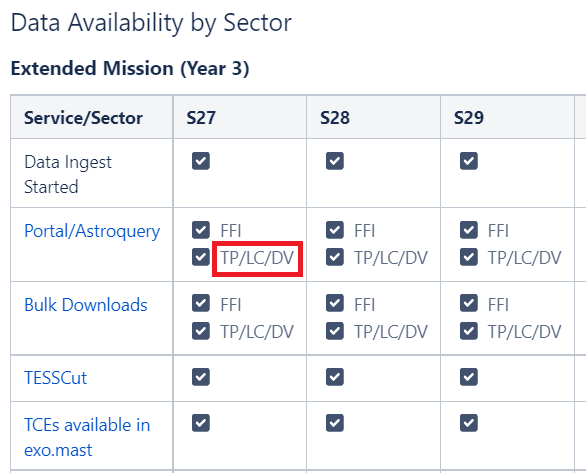
